In [2]:
model=None

In [32]:
import w2vAida
import analogy_completion
import pandas as pd
import numpy as np
import operator
import logging

In [33]:
## CONFIG
model_version = "w2v"   # one of s2v, aida-w2v, or w2v
gold_set = "SAT" # one of SAT, AGS
exclude_minority_vectors = False 
experiment_mode = "choose_best" # one of "choose_best", "don't choose wrong"
prototype_selection = "select_highest_relational_simialrity" # "select_highest_relational_simialrity", "select_highest_token_similarity"
verbose = True
use_local=True

In [34]:
if use_local:
    ### LOCAL VERSION
    if (model_version == "s2v"):
        model_file = "D:/data/analogy/pratima_w2v_models/s2v.model.bin"
        vocab_file = "D:/data/analogy/pratima_w2v_models/s2v.vocab"
        delimeter = "|"
    elif (model_version == "aida-w2v"):
        model_file = "D:/data/analogy/pratima_w2v_models/aida.model.bin"
        vocab_file = "D:/data/analogy/pratima_w2v_models/aida.vocab"
        delimeter = ":"
    if (model_version == "w2v"):
        model_file = "D:/data/analogy/pratima_w2v_models/w2v.model.bin"
        delimter = None
    logging.debug("version: "+model_version)
    if (gold_set == "AGS"):
        golddata_file = "C:/Users/chris/Documents/GitHub/SimilarityAndAnalogy/analogy/testData/AGS/AGS-V02.txt"
    else:
        golddata_file = "C:/Users/chris/Documents/GitHub/SimilarityAndAnalogy/analogy/testData/SAT/crowdruns/SAT_AGS_format.csv"
    log_path = "C:/Users/chris/Documents/GitHub/SimilarityAndAnalogy/analogy/btw17/log/"

In [35]:
if not use_local:
    ### VERSION on IS69
    if (model_version == "s2v"):
        model_file = "/opt3/home/pratima/thesis_final/models/s2v.model.bin"
        vocab_file = "/opt3/home/lofi/word2vec_models/s2v.vocab"
        delimeter = "|"
    elif (model_version == "aida"):
        model_file = "/opt3/home/pratima/thesis_final/models/aida.model.bin"
        vocab_file = "/opt3/home/lofi/word2vec_models/aida.vocab"
        delimeter = ":"
    logging.debug("version: "+model_version)
    if (gold_set == "AGS"):
        golddata_file = "/opt3/home/lofi/github/SimilarityAndAnalogy/analogy/testData/AGS/AGS-V02.txt"
    else:
        golddata_file = "/opt3/home/lofi/github/SimilarityAndAnalogy/analogy/testData/SAT/crowdruns/SAT_AGS_format.csv"
    log_path = "/opt3/home/lofi/github/SimilarityAndAnalogy/analogy/btw17/log/"

In [36]:
## logging
log_filename = model_version+"_"+gold_set+"_"+("NoMinority" if exclude_minority_vectors else "Minority")+".log"

from logging.handlers import RotatingFileHandler
import sys

log = logging.getLogger('')
log.setLevel(logging.DEBUG)
format = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")

#ch = logging.StreamHandler(sys.stdout)
#ch.setFormatter(format)
#log.addHandler(ch)

#fh = logging.handlers.RotatingFileHandler(log_path+log_filename, maxBytes=(1048576*5), backupCount=7)
fh = logging.FileHandler(log_path+log_filename, mode="w")
fh.setFormatter(format)

log.addHandler(fh)

In [37]:
### LOAD GOLD DATA

def loadGoldData_AGS(dataset):
    with open(dataset, 'r') as file:
        lines = file.readlines()
        simGold = []
        i = 0
        while i < len(lines):
            line = lines[i].strip()
            i += 1
            if line.startswith(":"):
                continue
            if line.startswith("\n"):
                i += 1
                continue
            splits = line.split(" ")
            correctedsplits = [ ]
            correctedsplits.append(splits[0])
            correctedsplits.append(splits[1])
            correctedsplits.append(splits[2])
            correctedsplits.append(splits[3])
            correctedsplits.append(splits[4])
            correctedsplits.append(splits[5])
            correctedsplits.append(splits[6])
            correctedsplits.append(splits[7])
            correctedsplits.append(splits[8])
            simGold.append(correctedsplits)
            #print(correctedsplits)
        return simGold


analogydataset = loadGoldData_AGS(golddata_file)

In [38]:
### Load Training Model. Note: s2v needs | delimeter, 
if model is None or not loaded_model==model_file:
    model=w2vAida.Word2Vec.load_word2vec_format(fname=model_file, binary=True, fvocab=vocab_file, delimeter=delimeter)
    loaded_model=model_file
    
    ## run word statistics for the current model
    full_words={}
    for challange in analogydataset:
        for i in range(0, 4):
            if not challange[i] in full_words:
                full_words[challange[i]]=[]
    ## LOAD VOCABULARY
    # iterate over the whole vocabulary....
    for key,value in model.vocab.items():
        # split the multi-prototype from the vocabulary into main word part, and prototype part
        freq = value.count
        split_key = key.split(delimeter)
        main_keyword = split_key[0]
        # iterate over the provided words, and check if it matches any token
        for word in full_words:
            # if we have indeed a match...
            if (word == main_keyword):
                # we keep a dictionary of statistics for each word, and add new prototypes to it when found
                full_words[main_keyword].append([key, freq])
    
    

In [39]:
## get rid of unwanted vectors
import copy
cutoff_ratio = 0.1

limited_words=copy.deepcopy(full_words)
for word, prototypes in limited_words.items():
    if len(prototypes) is not None and len(prototypes)>0:
        # find max
        max_prototype=None
        for prototype in prototypes:
            if prototype[1] is not None:    
                if max_prototype is None or prototype[1]>max_prototype[1]:
                    max_prototype=prototype
        if max_prototype is not None:
            for prototype in prototypes:
                if (prototype[1] is not None and prototype[1]<cutoff_ratio*max_prototype[1]):
                    limited_words[word].remove(prototype)
## get rid of unwanted vectors
import copy
cutoff_ratio = 0.1

limited_words=copy.deepcopy(full_words)
for word, prototypes in limited_words.items():
    if len(prototypes) is not None and len(prototypes)>0:
        # find max
        max_prototype=None
        for prototype in prototypes:
            if prototype[1] is not None:    
                if max_prototype is None or prototype[1]>max_prototype[1]:
                    max_prototype=prototype
        if max_prototype is not None:
            for prototype in prototypes:
                if (prototype[1] is not None and prototype[1]<cutoff_ratio*max_prototype[1]):
                    limited_words[word].remove(prototype)

In [ ]:
# just a test 
#if (model_version=="s2v"):
#    print(model.n_similarity(['egg|noun', 'chick|noun'], ['larva|noun', 'insect|noun']))
#print(model.n_similarity_new(['egg','chick'],['larva','insect'], used_words=limited_words))

In [26]:
### Similarity Function for highest relational similarity

from six import string_types
from numpy import ndarray
from operator import itemgetter

def n_similarity_version2(model, used_words, one, two):

    model.init_sims()

    if isinstance(one, string_types) and not two:
        # allow calls like most_similar('dog'), as a shorthand for most_similar(['dog'])
        one = [one]

    # add weights for each word, if not already present; default to 1.0 for positive and -1.0 for negative words
    one = [(word, 1.0) if isinstance(word, string_types + (ndarray,))
                            else word for word in one]
    two = [(word, -1.0) if isinstance(word, string_types + (ndarray,))
                             else word for word in two]

    p = [(word, 1.0) if isinstance(word, string_types)
                            else word for word in one]
    n = [(word, -1.0) if isinstance(word, string_types)
                             else word for word in two]

    p1 = p[:len(p)//2]
    p2 = p[len(p)//2:]
    sp1 = ', '.join('{}'.format(*el) for el in p1)
    sp2 = ', '.join('{}'.format(*el) for el in p2)
    n1 = n[:len(n)//2]
    n2 = n[len(n)//2:]
    sn1 = ', '.join('{}'.format(*el) for el in n1)
    sn2 = ', '.join('{}'.format(*el) for el in n2)

    wone, wtwo, wthree, wfour= [], [], [], []


    all_input = []
    all_counts = {}

    
    #print("Use given all words")
    for word, weight in one + two:
        for prototype in used_words[word]:    
            all_input.append(prototype[0])


    ## sort word back into the respective input buckets (yes, this is unnecesarily convoluted)
    for f in all_input:
        if sp1 in f:
            wone.append(f)
        elif sp2 in f:
            wtwo.append(f)
        elif sn1 in f:
            wthree.append(f)
        elif sn2 in f:
            wfour.append(f)

    if not wone or not wtwo or not wthree or not wfour:
        return 0.0

    intermediate=[]
    # iterate over the crossproduct of all variants of word one and all variants of word two
    for x1, y1, x2, y2 in [(x1,y1, x2, y2) for x1 in wone for y1 in wtwo for x2 in wthree for y2 in wfour]:
        similarity = model.n_similarity([x1,y1],[x2,y2])
        words = [x1, y1, x2, y2]
        intermediate.append([similarity, words])
        # store a tuple (similarity, (w1_variant, w2_variant))
        print("{}({}) {}({})  :: {}({})  {}({})   >> {}".
              format(x1, model.vocab[x1].count, y1, model.vocab[y1].count,
                     x2, model.vocab[x2].count, y2, model.vocab[y2].count, similarity))
    m = max(intermediate,key=itemgetter(0))[0]   
    return m

In [27]:
r_columns=('a1','a2','b1','b2','ags_rating','model_rating','difficulty')
raw_result = pd.DataFrame(columns=r_columns)
result_file_name=log_path+model_version+"_"+("NoMinority" if exclude_minority_vectors else "Minority")+".result.csv"

In [40]:
### get raw results for all challanges in the Gold data

if exclude_minority_vectors:
    word_list = limited_words
else:
    word_list = full_words

countlines = 0
for value in analogydataset:
    #if(value[6]==word):
    if model_version=="w2v":
        if (prototype_selection=="select_highest_relational_simialrity"):
             r_similarity = n_similarity_version2(model=model, one=[value[0], value[1]],two=[value[2],value[3]], used_words=word_list)
        else:
            r_similarity = model.n_similarity_new([value[0], value[1]],[value[2],value[3]], all_words=word_list)
    else:
        r_similarity = model.n_similarity([value[0], value[1]],[value[2],value[3]])

    # print("{}:{} :: {}:{}  >> {}    reference rating {}".format(value[0], value[1], 
    #                                                            value[2], value[3], r_similarity, value[4]))

    countlines+=1

    row = pd.DataFrame([[value[0],value[1],value[2],value[3],value[4],r_similarity, value[8]]],columns=r_columns)

    raw_result=raw_result.append(row)
raw_result.to_csv(result_file_name, encoding='utf-8')
              

lull(None) trust(None)  :: balk(None)  fortitude(None)   >> 0.5146278259570958
lull(None) trust(None)  :: betray(None)  loyalty(None)   >> 0.5689497435279984
lull(None) trust(None)  :: cajole(None)  compliance(None)   >> 0.6120011243591991
lull(None) trust(None)  :: hinder(None)  destination(None)   >> 0.5274496614658818
lull(None) trust(None)  :: soothe(None)  passion(None)   >> 0.6273371926521762
swarm(None) bee(None)  :: school(None)  fish(None)   >> 0.42596822958951586
swarm(None) bee(None)  :: venison(None)  deer(None)   >> 0.3062153102748053
swarm(None) bee(None)  :: oxen(None)  cow(None)   >> 0.3495419327108673
swarm(None) bee(None)  :: peak(None)  mountain(None)   >> 0.28796454903112756
swarm(None) bee(None)  :: skin(None)  lion(None)   >> 0.4044617612097481
obtain(None) steal(None)  :: quest(None)  search(None)   >> 0.671144839944906
obtain(None) steal(None)  :: ask(None)  interrogate(None)   >> 0.7316215507771677
obtain(None) steal(None)  :: testify(None)  perjure(None)   >> 

In [41]:
raw_result['ags_rating'] = raw_result['ags_rating'].apply(pd.to_numeric)
grouped = raw_result.groupby(("a1", "a2"))

In [42]:
# define thresholds for definitly corretc, definitly incorrect, and neutral
correct_threshold = 4
incorrect_threshold = 2

In [43]:
### more complex statistics: correct >> incorrect

### create result file
result_columns=('name','model','difficulty')
result = pd.DataFrame(columns=result_columns)
result_file_name=log_path+model_version+"_"+("NoMinority" if exclude_minority_vectors else "Minority")+".result.final.csv"



## check for correctness
count = 0
correct = 0
for name, group in grouped:
    is_correct = False
    #### DON'T CHOOSE WRONG STRATEGY 
    if experiment_mode=="don't choose wrong":
        #print(group)
        ## select all rows which have a the maximum value for model rating
        correct_in_ags= group[group["ags_rating"] >= correct_threshold]
        incorrect_in_ags= group[group["ags_rating"] <= incorrect_threshold]

        violating_rows=pd.DataFrame(columns=r_columns)

        is_correct = True
        # compare all correct rows to all incorrect rows.
        for i1, c_row in correct_in_ags.iterrows():
            for i2, i_row in incorrect_in_ags.iterrows(): 
                #print(i_row)
                #print(c_row)
                # if an incorrect row has a better rating than a correct row, it is wrong
                if i_row["model_rating"]>=c_row["model_rating"]:
                    violating_rows=violating_rows.append([i_row, c_row])
                    is_correct = False
                else:
                    pass
            ## debug errors to console
            if not is_correct:
                print(violating_rows.to_string(columns=r_columns))
    if experiment_mode=="choose_best":
        
        max_row_model=group.iloc[0]
        for ix, row in group.iterrows():
            if row["model_rating"]>max_row_model["model_rating"]:
                max_row_model=row
        max_row_ags=group.iloc[0]
        for ix, row in group.iterrows():
            if row["ags_rating"]>max_row_ags["ags_rating"]:
                max_row_ags=row
        is_correct=(max_row_model["b1"]==max_row_ags["b1"] and max_row_model["b2"]==max_row_ags["b2"])
        if not is_correct:
            print(group)
       
        
        
    count+=1
    if (is_correct):
        correct+=1
    difficulty = group.iloc[0]["difficulty"]
    # print(difficulty)
    resultrow = pd.DataFrame([[str(name).replace(",","").replace("(","").replace(")","").replace("'",""), 
                               1 if is_correct else 0, difficulty]],columns=result_columns)
    result=result.append(resultrow)

result.model=result.model.astype(int)
overal_correctness = float(correct)/count

      a1             a2        b1           b2  ags_rating  model_rating  \
0  abash  embarrassment   dislike    hypocrisy         1.0      0.000000   
0  abash  embarrassment   pretend  imagination         1.0      0.000000   
0  abash  embarrassment     annoy   irritation         5.0      0.000000   
0  abash  embarrassment   suspect   illegality         1.0      0.000000   
0  abash  embarrassment  demolish   renovation         1.0      0.000000   
0  abash  embarrassment   dislike    hypocrisy         1.0      0.764812   
0  abash  embarrassment   pretend  imagination         1.0      0.727634   
0  abash  embarrassment     annoy   irritation         5.0      0.750150   
0  abash  embarrassment   suspect   illegality         1.0      0.690126   
0  abash  embarrassment  demolish   renovation         1.0      0.505911   

  difficulty  
0     medium  
0     medium  
0     medium  
0     medium  
0     medium  
0     medium  
0     medium  
0     medium  
0     medium  
0     medium 

In [44]:
print(overal_correctness)

0.2336182336182336


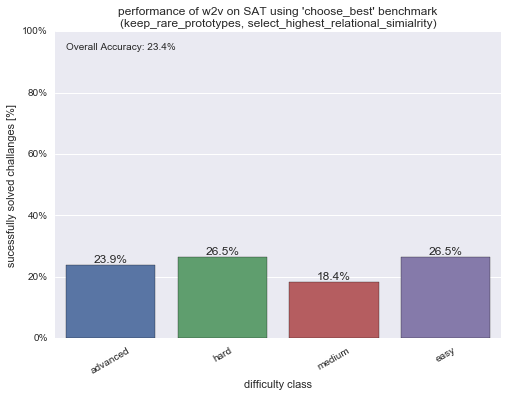

In [45]:

difficulty_labels=("advanced", "hard", "medium", "easy")

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

##setup styles
sns.set(style="darkgrid")

ax = sns.barplot(data=result, y="model", x="difficulty", ci=None, palette="deep", order=difficulty_labels)
ax.set_ylim(0,1)
ax.set_ylabel("sucessfully solved challanges [%]")
ax.set_xlabel("difficulty class")
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)
## add persentage axis
ax.set_yticklabels(map('{:.0f}%'.format, 100*ax.yaxis.get_majorticklocs()))
# add annotations
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:1.1f}%'.format(y*100), (x.mean(), y), 
            ha='center', va='bottom')


##
plt.text(-0.4, 0.94, ("Overall Accuracy: {:.1f}%".format(overal_correctness*100)), ha ='left', fontsize = 10)
title="performance of "+model_version+" on "+gold_set+" using '"+experiment_mode+"' benchmark\n"
title+="("+("exclude_rare_prototypes" if exclude_minority_vectors else "keep_rare_prototypes")+", "
title+=prototype_selection+")"
plt.title(title)
plt.show()
ax.get_figure().savefig(log_path+title.replace("\n", "_")+".png", format='png', dpi=300)

In [46]:
print(exclude_minority_vectors) 

False


In [47]:
print(full_words["patient"])

[['patient', None]]


In [27]:
print(limited_words["patient"])

[['patient|adj', 933], ['patient|noun', 7628], ['patient|verb', 7]]
